In [1]:
import sys
sys.path.append(r'C:\Users\Jameshuckle\Dropbox\My-Portfolio\AlgorithmicTrading\utils')
from trading_util import (download_data_local_check, prep_stock_data, prep_fx_data, calc_sharpe, calc_romad)
from candlestick_embeddings_util import create_candlestick_corpus

from tqdm import tqdm_notebook as tqdm
from win10toast import ToastNotifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import random
import time
import copy
import os
import gc

%matplotlib inline

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import initializers
from sklearn.metrics import (mean_squared_error, accuracy_score)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy import interpolate

In [3]:
# def global_set_seed(seed_value):
#     os.environ['PYTHONHASHSEED']=str(seed_value)
#     random.seed(seed_value)
#     np.random.seed(seed_value)
#     tf.random.set_seed(seed_value)
# global_set_seed(0)

np.random.seed = 1

In [4]:
data_source = 'fx' # 'fx', 'stock'

if data_source == 'fx':
    ### FX data #######
    fx_files = [
                 'EURUSD_1h_2003-2010.csv', 'EURUSD_1h_2010-2020.csv',
                 'USDJPY_1h_2003-2010.csv', 'USDJPY_1h_2010-2020.csv',
                 'NZDUSD_1h_2003-2020.csv',
                 'AUDUSD_1h_2003-2020.csv',
                 'USDCAD_1h_2003-2020.csv',
                 ]

    loaded_files = prep_fx_data(fx_files)
        
if data_source == 'stock':
    ### stock data ######
    start = '2000-01-01'
    end = '2020-04-28'
    ## download data
    all_stock_data = download_data_local_check('SP500', start, end)
    loaded_files = prep_stock_data(all_stock_data, filter_start_date_tuple=None) #(2015,1,1)

EURUSD_1h_2003-2010.csv
EURUSD_1h_2010-2020.csv
USDJPY_1h_2003-2010.csv
USDJPY_1h_2010-2020.csv
NZDUSD_1h_2003-2020.csv
AUDUSD_1h_2003-2020.csv
USDCAD_1h_2003-2020.csv


In [5]:
def increase_wave_len(full_wave, wave_len_increase):
    full_wave[-2] = full_wave[0] # match the start and end
    x = np.arange(len(full_wave))
    f = interpolate.interp1d(x, full_wave)
    x_new = np.arange(0,len(full_wave)-1, 1/wave_len_increase)
    y_new = f(x_new)
    return y_new
# new_wave = increase_wave_len(full_wave, wave_len_increase=1)
# plt.plot(new_wave)

def create_waves(starting_price=100, overall_wave_len=0.1, overall_wave_amp=1, 
                     secondary_wave_amp=0.5, noise_amp=0, trend=0):
    data = []
    slow_cosine_wave = np.cos(np.arange(0, 12.7, 0.1))
    fast_cosine_wave = np.cos(np.arange(0, 12.7 * 6, 0.1 * 6)) * secondary_wave_amp
    full_wave = slow_cosine_wave + fast_cosine_wave
    full_wave = increase_wave_len(full_wave, overall_wave_len)
    noise = np.random.randn(len(full_wave)) * noise_amp
    full_wave = (full_wave  + noise) * overall_wave_amp
    calc_start_diff = starting_price - full_wave[0] 
    full_wave += calc_start_diff
    full_wave += ((np.array(range(len(full_wave)+1))**trend) - 1)[1:]  # [1:] stops **trend giving neg values
    return full_wave

def wave_data(wave_cycles=100, starting_price=100):
    data = np.array([])
    for w in range(wave_cycles):
        full_wave = create_waves(starting_price=starting_price, overall_wave_len=1, overall_wave_amp=1, 
                                     secondary_wave_amp=0.5, noise_amp=0, trend=0)
        starting_price = full_wave[-1]
        data = np.concatenate([data, full_wave])
    return data

def any_data(dataset_type, cols, file_name=''):
    if dataset_type == 'wave':
        raw_data = wave_data(wave_cycles=100, starting_price=100)
        raw_data = np.expand_dims(raw_data, axis=1)
    elif dataset_type == 'random':
        raw_data = np.random.rand(12600) + 100
        raw_data = np.expand_dims(raw_data, axis=1)
    elif dataset_type == 'monte_carlo':
        raw_data = pd.read_csv('monte_carlo_audusd.csv').to_numpy()
    elif dataset_type == 'stock':
        if read_single_file:
            #print('Reading in single file:',file_name)
            raw_data = process_file(file_name)
        else:
            #print('Indexing file from loaded_files:',file_name)
            raw_data = loaded_files[file_name]
        if resample:
            raw_data = raw_data.resample(resample).agg({'Open':'first','High':'max','Low':'min','Close':'last'})
        raw_data.dropna(inplace=True)
        raw_data = raw_data[cols].to_numpy()
    else:
        raise Exception(f'datset of type {dataset} not recognised')
       
    return raw_data

def categorical_classification(y, data, std_thresh):
    y = y.copy()
    pop_mean = data.mean()
    pop_std = data.std() * std_thresh
    large_neg = y < (pop_mean - pop_std)
    large_pos = y > (pop_mean + pop_std)
    small_move = ~(large_neg | large_pos)
    y[large_neg] = 0
    y[small_move] = 1
    y[large_pos] = 2
    return y    

def sliding_window(data, window = 4, step = 2):
    shape = (data.size - window + 1, window)
    strides = data.strides * 2
    window_data = np.lib.stride_tricks.as_strided(data, strides=strides, shape=shape)[0::step]
    return window_data

def create_window_data(raw_data, data, window, cols, problem_type, num_bars): 
    data_windows = sliding_window(data=data.flatten(), window=window * len(cols), step=len(cols)) 
    data_windows = data_windows.reshape(-1, window, len(cols))
    
    y_close_prices = raw_data[:, -1][window + (num_bars - 1):]
    x = data_windows[:len(y_close_prices)]

    x_close_prices = raw_data[:, -1][window - 1: len(y_close_prices) + window - 1]
    y_pct_diff = (y_close_prices - x_close_prices) / x_close_prices

    if problem_type == 'regression':
        y = y_close_prices
        if data_percentage_diff:
            y = y_pct_diff
    elif problem_type == 'binary':
        y = np.where(y_pct_diff < 0, 0, 1) # classification task
    elif problem_type == 'category':
        y = categorical_classification(y_pct_diff, data, std_thresh=0.29)
    return x, y, y_pct_diff

def bool_argmax(bool_array):
    if bool_array.sum() == 0:
        return -1
    else:
        return np.argmax(bool_array)

def rp(price):
    return round(price * 10**tick_size_decimals) / 10**tick_size_decimals

def calc_binary_stop_target(raw_data, bar_horizon=100, stop_size_pct=0.004, target_size_r_r=1, tick_size_decimals=4):
    hit_neither_target_or_stop = 0
    hit_target_and_stop = 0
    
    random_numbers = np.random.rand(raw_data.shape[0])
    random_win_thresh = 1/(target_size_r_r+1)

    binary_classes = []
    for row_idx in range(raw_data.shape[0]):
        if row_idx == raw_data.shape[0] -1:
            binary_classes.append(0)
            continue
            
        close_price = raw_data[row_idx, 3]
        child_order_distance = rp(close_price * stop_size_pct)
        target_price = rp(close_price + child_order_distance)
        stop_price = rp(close_price - child_order_distance)

        highs_price_range = raw_data[row_idx+1:row_idx+bar_horizon, 1]
        lows_price_range = raw_data[row_idx+1:row_idx+bar_horizon, 2]

        bool_target = highs_price_range >= target_price
        target_bar_idx = bool_argmax(bool_target)

        bool_stop = lows_price_range <= stop_price
        stop_bar_idx = bool_argmax(bool_stop)

        if target_bar_idx == -1 and stop_bar_idx == -1:
            hit_neither_target_or_stop += 1
            last_bar_close_price = raw_data[row_idx+1:row_idx+bar_horizon, 3][-1]
            if last_bar_close_price <= close_price:
                binary_class = 0
            else:
                binary_clas = 1
        elif target_bar_idx == -1:
            binary_class = 0
        elif stop_bar_idx == -1:
            binary_class = 1
        elif stop_bar_idx < target_bar_idx:
            binary_class = 0
        elif target_bar_idx < stop_bar_idx:
            binary_class = 1
        elif target_bar_idx == stop_bar_idx:
            hit_target_and_stop +=1
            random_win = random_numbers[row_idx] <= random_win_thresh
            binary_class = int(random_win)
        binary_classes.append(binary_class)
    print('hit_target_and_stop:', hit_target_and_stop, 'hit_neither_target_or_stop:', hit_neither_target_or_stop)
    return np.array(binary_classes[window-1:-1])

def display_stop_target(x, y, start=0, end=100, vline=33, hline=0.638):
    plot_data = pd.DataFrame(x[:,-1])
    plot_data.columns = 'open','high','low','close'
    plot_data['y'] = y
    child_order_dist = plot_data['close'] * stop_size_pct
    plot_data['target'] = plot_data['close'] + child_order_dist
    plot_data['stop'] = plot_data['close'] - child_order_dist

    window_plot_data = plot_data[start:end] ## change me
    
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios':[3,1]}, figsize=(20,12))
    plt.subplots_adjust(wspace=0, hspace=0)
    window_plot_data['high'].plot(c='grey', ax=ax[0])
    window_plot_data['low'].plot(c='grey', ax=ax[0])
    window_plot_data['close'].plot(c='k', ax=ax[0])
    window_plot_data['target'].plot(c='g', ax=ax[0])
    window_plot_data['stop'].plot(c='r', ax=ax[0])
    window_plot_data['y'].plot(c='k', ax=ax[1])
    
    ax[0].axvline(vline, c='k', linestyle='dashed') ## change me
    ax[0].axhline(hline, c='k', linestyle='dashed') ## change me
    plt.show()
    
def open_diff(numpy_ohlc):
    diff_data_numpy = np.zeros(numpy_ohlc.shape)
    # open vs close
    diff_data_numpy[1:,0] = (numpy_ohlc[1:,0] - numpy_ohlc[:-1,3]) / numpy_ohlc[:-1,3]
    # high, low, close vs open
    diff_data_numpy[:,[1,2,3]] = ((numpy_ohlc[:,[1,2,3]].T - numpy_ohlc[:,0]) / numpy_ohlc[:,0]).T 
    return diff_data_numpy

def dataset_diff(train_data_raw, test_data_raw, data_percentage_diff, cols):
    if data_percentage_diff in ['ohlc_diff', 'uni_diff']:
        train_data = np.diff(train_data_raw, axis=0) / train_data_raw[:-1] # pct_change of data
        train_data = np.insert(train_data, 0, [0]*len(cols), axis=0)
        test_data = np.diff(test_data_raw, axis=0) / test_data_raw[:-1] # pct_change of data
        test_data = np.insert(test_data, 0, [0]*len(cols), axis=0)
    elif data_percentage_diff == 'close_diff':
        train_data = ((train_data_raw[1:].T - train_data_raw[:-1,-1]) / train_data_raw[:-1,-1]).T
        train_data = np.insert(train_data, 0, [0]*len(cols), axis=0)
        test_data = ((test_data_raw[1:].T - test_data_raw[:-1,-1]) / test_data_raw[:-1,-1]).T
        test_data = np.insert(test_data, 0, [0]*len(cols), axis=0)
    elif data_percentage_diff == 'open_diff':
        train_data = open_diff(train_data_raw)
        test_data = open_diff(test_data_raw)
    else:
        train_data = train_data_raw
        test_data = test_data_raw
    return train_data, test_data

def dataset_target_stop():
    y = calc_binary_stop_target(train_data_raw, bar_horizon, stop_size_pct, target_size_r_r, tick_size_decimals)
    y_test = calc_binary_stop_target(test_data_raw, bar_horizon, stop_size_pct, target_size_r_r, tick_size_decimals)
    y_pct_diff = np.where(y == 0, -1, 1) * stop_size_pct
    y_test_pct_diff = np.where(y_test == 0, -1, 1) * stop_size_pct
    return y, y_test, y_pct_diff, y_test_pct_diff

def fast_fourier_transform(X, n_coefs=10):
    n_samples, window = X.shape
    dft = DiscreteFourierTransform(n_coefs=n_coefs, norm_mean=False,
                                   norm_std=False)
    X_dft = dft.fit_transform(X)

    # Compute the inverse transformation
    if n_coefs % 2 == 0:
        real_idx = np.arange(1, n_coefs, 2)
        imag_idx = np.arange(2, n_coefs, 2)
        X_dft_new = np.c_[
            X_dft[:, :1],
            X_dft[:, real_idx] + 1j * np.c_[X_dft[:, imag_idx],
                                            np.zeros((n_samples, ))]
        ]
    else:
        real_idx = np.arange(1, n_coefs, 2)
        imag_idx = np.arange(2, n_coefs + 1, 2)
        X_dft_new = np.c_[
            X_dft[:, :1],
            X_dft[:, real_idx] + 1j * X_dft[:, imag_idx]
        ]
    X_irfft = np.fft.irfft(X_dft_new, window)  
    return X_irfft
    
def create_dataset(file_name, **kwargs):
    raw_data = any_data(dataset_type, cols, file_name=file_name)
            
    train_end_idx = int(len(raw_data) * train_split)
    train_data_raw = raw_data[:train_end_idx]
    test_data_raw = raw_data[train_end_idx:]
    
    if data_percentage_diff:
        train_data, test_data = dataset_diff(train_data_raw, test_data_raw, data_percentage_diff, cols)
        
    x, y, y_pct_diff = create_window_data(train_data_raw, train_data, window, cols, problem_type, num_bars)   
    x_test, y_test, y_test_pct_diff = create_window_data(test_data_raw, test_data, window, cols, problem_type, num_bars)
    
    if target_stop:
        y = calc_binary_stop_target(train_data_raw, bar_horizon, stop_size_pct, target_size_r_r, tick_size_decimals)
        y_test = calc_binary_stop_target(test_data_raw, bar_horizon, stop_size_pct, target_size_r_r, tick_size_decimals)
        y_pct_diff = np.where(y == 0, -1, 1) * stop_size_pct
        y_test_pct_diff = np.where(y_test == 0, -1, 1) * stop_size_pct        
    
    x_shape = x.shape
    x_test_shape = x_test.shape
    
    if standardize:
        global scaler
        if standardize == 'std':
            scaler = StandardScaler()
        elif standardize == 'min_max':
            scaler = MinMaxScaler((-1,1))
        x = scaler.fit_transform(x.reshape(x_shape[0], -1))
        x = x.reshape(x_shape)
        x_test = scaler.transform(x_test.reshape(x_test_shape[0], -1))
        x_test = x_test.reshape(x_test_shape)
        if problem_type == 'regression':
            y_scaler = StandardScaler()
            y = y_scaler.fit_transform(np.expand_dims(y, axis=1))
            y_test = y_scaler.transform(np.expand_dims(y_test, axis=1))
            
    if pca_features:
        pca = PCA(n_components=pca_features*len(cols))
        x = pca.fit_transform(x.reshape(x_shape[0],-1))
        x = x.reshape(x_shape[0], -1, x_shape[2])
        x_test = pca.transform(x_test.reshape(x_test_shape[0], -1))
        x_test = x_test.reshape(x_test_shape[0], -1, x_test_shape[2])
        
    if embeddings:
        assert not standardize and not pca_features
        train_data_labels = create_candlestick_corpus(train_data_raw, train=True, pandas_with_dates=False)[:,-1]
        test_data_labels = create_candlestick_corpus(train_data_raw, train=False, pandas_with_dates=False)[:,-1]
        
        if embedding_type == 'light':
            train_data_embedding = train_data_labels.astype(int)
            test_data_embedding = test_data_labels.astype(int)
        else:
            with open(f'candlestick_embeddings_{vector_size}.pkl','rb') as f:
                embeddings_dict = pickle.load(f)
            data_labels = set(np.concatenate([train_data_labels, test_data_labels]))
            unknown_labels = [label for label in data_labels if label not in list(embeddings_dict.keys())]
            unknown_embeddings = {label: np.random.rand(vector_size) for label in unknown_labels}
            embeddings_dict = {**embeddings_dict, **unknown_embeddings}    
            train_data_embedding = np.array([embeddings_dict[label] for label in train_data_labels])
            test_data_embedding = np.array([embeddings_dict[label] for label in test_data_labels])   
            
        x_embed = sliding_window(data=train_data_embedding.flatten(), window=window * vector_size, step=vector_size) 
        x_embed = x_embed.reshape(-1, window, vector_size)
        x = x_embed[:x.shape[0]]
        
        x_test_embed = sliding_window(data=test_data_embedding.flatten(), window=window * vector_size, step=vector_size) 
        x_test_embed = x_test_embed.reshape(-1, window, vector_size)
        x_test = x_test_embed[:x_test.shape[0]]
        
    if problem_type != 'regression':
        elem , count = np.unique(y, return_counts=True)
        
    return x, y, x_test, y_test, y_pct_diff, y_test_pct_diff, train_data_raw, test_data_raw

In [6]:
def save_numpy_to_csv_all_files():
    header = True
    mode = 'w'
    now = time.time()
    for file_name in tqdm(list(loaded_files.keys())):
        print('saving',file_name)
        x, y, x_test, y_test, y_pct_diff, y_test_pct_diff, train_data_raw, test_data_raw = create_dataset(file_name=file_name)
        my_shape_x = x.shape
        all_data = pd.DataFrame(x.reshape(-1, my_shape_x[1] * my_shape_x[2]))
        all_data['y'] = y
        all_data.to_csv('all_data_train.csv', mode=mode, header=header, index=False)

        my_shape_x_test = x_test.shape
        all_data = pd.DataFrame(x_test.reshape(-1, my_shape_x_test[1] * my_shape_x_test[2]))
        all_data['y'] = y_test
        all_data.to_csv('all_data_test.csv', mode=mode, header=header,  index=False)
        header = False
        mode = 'a'
        gc.collect()
    print('finished in:',int(time.time() - now), 'seconds')

def write_csv_to_tfrecords(file_name_no_extension):
    ### Read csv into pandas and save to tfrecords
        csv = pd.read_csv(f'{file_name_no_extension}.csv').values
        with tf.io.TFRecordWriter(f'{file_name_no_extension}.tfrecords') as writer:
            for row in tqdm(csv):
                features, label = row[:-1], row[-1]
                example = tf.train.Example()
                example.features.feature["features"].float_list.value.extend(features)
                example.features.feature["label"].float_list.value.append(label)
                writer.write(example.SerializeToString())
        
def parse_tfrecord(serialized_example):
    input_vector_size = vector_size if embeddings else len(cols)
    feature_description = {
        'features': tf.io.FixedLenFeature(shape=(input_len, input_vector_size), dtype=tf.float32),
        'label': tf.io.FixedLenFeature(shape=(1), dtype=tf.float32),
    }
    example = tf.io.parse_single_example(serialized_example, feature_description)
    #example['features'] = tf.reshape(example['features'], shape=(input_len, len(cols)))
    
    return example['features'], example['label']

def create_tfrecord_dataset(file_name_no_extension):
    ### Write csv to tfrecords
    write_csv_to_tfrecords(file_name_no_extension)
    ### Read in single file
    dataset = tf.data.TFRecordDataset(filenames = [f'{file_name_no_extension}.tfrecords'])
#     for row in dataset.take(1):
#         print(parse_tfrecord(row))
    ### Parse files
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=4)
    ### Cache parsed file onto disk
    [os.remove(file) for file in os.listdir() if f'{file_name_no_extension}_cache' in file] # remove old cache files
    dataset = dataset.cache(filename=f'{file_name_no_extension}_cache')
    print('caching:',f'{file_name_no_extension}_cache')
    dataset = dataset.batch(batch_size=batch_size).prefetch( 
        buffer_size=tf.data.experimental.AUTOTUNE) #.shuffle(buffer_size=1024, seed=1)
    return dataset

In [7]:
from tensorflow.keras import layers

seed_value = 1
layer_kwargs = {'kernel_initializer':initializers.glorot_uniform(seed=seed_value),
                'bias_initializer':initializers.Constant(0.1),
               }

def dnn_model(lr1, lr2, drop_rate, input_len, output_layer):
    input_vector_size = vector_size if embeddings else len(cols)
    model = tf.keras.Sequential([
        layers.Reshape((input_len * input_vector_size,), input_shape=[input_len, input_vector_size]),
        layers.Dense(units=1000, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        layers.Dropout(drop_rate),
        layers.Dense(units=1000, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        layers.Dropout(drop_rate),
        layers.Dense(units=1000, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        layers.Dropout(drop_rate),
        layers.Dense(units=500, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        layers.Dropout(drop_rate),
        layers.Dense(units=500, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        layers.Dropout(drop_rate),
        layers.Dense(units=500, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        layers.Dropout(drop_rate),
        layers.Dense(units=500, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        layers.Dropout(drop_rate),
        layers.Dense(units=500, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        layers.Dropout(drop_rate),
        layers.Dense(units=500, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        layers.Dropout(drop_rate),
        layers.Dense(units=500, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        layers.Dropout(drop_rate),
        layers.Dense(units=500, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        output_layer,
    ])
    return model

def conv1d_model(lr1, lr2, drop_rate, input_len, output_layer):
    model = tf.keras.Sequential([
        layers.Conv1D(filters=10, kernel_size=4, input_shape=[input_len, len(cols)], **layer_kwargs),        
        layers.Flatten(),
        layers.Dense(units=10, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        output_layer,
    ])
    return model

def inception1d_model(lr1, lr2, drop_rate, input_len, output_layer):
    input_img = layers.Input(shape=(input_len, 1))
    ### 1st layer
    layer_1 = layers.Conv1D(10, 1, padding='same', activation='relu', **layer_kwargs)(input_img)
    layer_1 = layers.Conv1D(10, 5, padding='same', activation='relu', **layer_kwargs)(layer_1)

    layer_2 = layers.Conv1D(10, 1, padding='same', activation='relu', **layer_kwargs)(input_img)
    layer_2 = layers.Conv1D(10, 10, padding='same', activation='relu', **layer_kwargs)(layer_2)

    layer_3 = layers.MaxPooling1D(3, strides=1, padding='same')(input_img)
    layer_3 = layers.Conv1D(10, 1, padding='same', activation='relu', **layer_kwargs)(layer_3)

    mid_1 = layers.concatenate([layer_1, layer_2, layer_3], axis = 2)
    flat_1 = layers.Flatten()(mid_1)

    dense_1 = layers.Dense(128, activation='relu', **layer_kwargs)(flat_1)
    dense_2 = layers.Dense(64, activation='relu', **layer_kwargs)(dense_1)
    dense_3 = layers.Dense(32, activation='relu', **layer_kwargs)(dense_2)
    output = output_layer(dense_3)
    model = tf.keras.models.Model([input_img], output)
    return model

def lstm_model(lr1, lr2, drop_rate, input_len, output_layer):
    input_vector_size = vector_size if embeddings else len(cols)
    model = tf.keras.Sequential([
        layers.LSTM(units=500, return_sequences=True, input_shape=[None, input_vector_size], **layer_kwargs),   
        layers.LSTM(units=500, return_sequences=False, **layer_kwargs), 
        #layers.LSTM(units=32, **layer_kwargs), 
        layers.Dense(units=500, activation='relu', kernel_regularizer=l1_l2(lr1, lr2), **layer_kwargs),
        output_layer,
    ])
    return model

In [8]:
window = 10
pca_features = False # False, 10
standardize = 'std' #'std', 'min_max'
data_percentage_diff = 'close_diff' # False, 'close_diff', 'ohlc_diff', 'open_diff'
train_split = 0.7
resample = None # None '1D', '4H', '1W'
read_single_file = None #all_files[3] #None
loaded_data = loaded_files

num_bars = 10
problem_type = 'binary' #'regression' 'binary' 'category'
dataset_type = 'stock' #'wave', 'random', 'stock', 'monte_carlo'
cols = ['Open', 'High', 'Low', 'Close'] if dataset_type == 'stock' else ['univariate']
#cols = ['Close'] if dataset_type in ['stock','monte_carlo'] else ['univariate']

###
input_len = pca_features if pca_features else window
###

## target/stop binary outcomes ##
target_stop = False 
if target_stop:
    num_bars = 1 # must be equal to 1!
    problem_type = 'binary'
    dataset_type = 'stock'
    cols = ['Open', 'High', 'Low', 'Close']
    bar_horizon = 10000 # how long to wait for stop or target hit, otherwise assign 1 if in profit or 0 if not
    stop_size_pct = 0.0050 # size of stop in pct
    target_size_r_r = 1 #at the moment it only makes sense to keep it at 1
    tick_size_decimals = 10 # used for rounding (no that important)

embeddings = False
embedding_type = None #None 'light'
if embeddings:
    standardize = False 
    pca_features = False
    vector_size = 200 # 200, 4
    if embedding_type == 'light':
        vector_size = 1
    
generator = True
if generator: 
    ## save all stocks to csv and tfrecords, then load tfrecords as dataset
    save_numpy_to_csv_all_files()
    batch_size = 1000
    train_dataset = create_tfrecord_dataset('all_data_train')
    test_dataset = create_tfrecord_dataset('all_data_test')
else:
    ### load single stock into numpy
    x, y, x_test, y_test, y_pct_diff, y_test_pct_diff, train_data_raw, test_data_raw = create_dataset(
        file_name=list(loaded_files.keys())[4])

saving EURUSD_1h_2003-2010.csv
saving EURUSD_1h_2010-2020.csv
saving USDJPY_1h_2003-2010.csv
saving USDJPY_1h_2010-2020.csv
saving NZDUSD_1h_2003-2020.csv
saving AUDUSD_1h_2003-2020.csv
saving USDCAD_1h_2003-2020.csv

finished in: 30 seconds



caching: all_data_train_cache



caching: all_data_test_cache


In [9]:
#display_stop_target(x_test, y_test, start=0, end=300, vline=40, hline=40)
# pd.Series(y_pct_diff).cumsum().plot()

In [10]:
tf.keras.backend.clear_session()

lr1 = 0 #1e-6
lr2 = 0 #1e-3
drop_rate = 0.1 #0.1 #0.2

###################################################################
if problem_type == 'binary': 
    output_layer = tf.keras.layers.Dense(units=1, activation='sigmoid', **layer_kwargs)
elif problem_type == 'category': 
    output_layer = tf.keras.layers.Dense(units=3, activation='softmax', **layer_kwargs)
else: 
    output_layer = tf.keras.layers.Dense(units=1, activation=None, **layer_kwargs)

###    
    
model = dnn_model(lr1, lr2, drop_rate, input_len, output_layer)
#model = conv1d_model(lr1, lr2, drop_rate, input_len, output_layer)
#model = inception1d_model(lr1, lr2, drop_rate, input_len, output_layer)
#model = lstm_model(lr1, lr2, drop_rate, input_len, output_layer)

total_epochs=0

## Train model

In [11]:
############################################################
adam = tf.keras.optimizers.Adam(learning_rate=1e-4)

if problem_type == 'binary': 
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
elif problem_type == 'category':
    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
else:
    rmse = tf.keras.metrics.RootMeanSquaredError(name='root_mean_squared_error', dtype=None)
    model.compile(optimizer=adam, loss='mse', metrics=[rmse])

gc.collect()
checkpoint_path = 'C:\\Users\\Jameshuckle\\Documents\\Algo_Trading\\model_checkpoints\\model.ckpt'
#cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)
#model.load_weights(checkpoint_path)

plot_lr_rate = False
decrease_lr_rate = False
validation = True

epochs = 100

kwargs = {'verbose':2, 'epochs':epochs, 'shuffle':False, 'callbacks':[]}
                    
if plot_lr_rate:
    kwargs['callbacks'].append(tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / (epochs / 7))))

elif decrease_lr_rate:
    kwargs['callbacks'].append(tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 / 10**(epoch / epochs))) #1e-2
    #kwargs['callbacks'].append(tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3))

if validation:
    kwargs['validation_data'] = (x_test, y_test) if not generator else test_dataset

if generator:
    ### Parellelize loading
    history = model.fit(x=train_dataset, **kwargs)
else:
    batch_size = 1000
    history = model.fit(x, y, batch_size=batch_size, **kwargs)
                        
model.save_weights(checkpoint_path)
print('\n---------------')
total_epochs += epochs
print('\ntotal_epochs',total_epochs)
gc.collect()

# toaster = ToastNotifier()
# toaster.show_toast("Finished Training!", "Hello world", duration=3, threaded=True)

Epoch 1/100
361/361 - 15s - loss: 0.6950 - accuracy: 0.5070 - val_loss: 0.6954 - val_accuracy: 0.5030
Epoch 2/100
361/361 - 4s - loss: 0.6938 - accuracy: 0.5050 - val_loss: 0.6951 - val_accuracy: 0.5030
Epoch 3/100
361/361 - 4s - loss: 0.6936 - accuracy: 0.5067 - val_loss: 0.6940 - val_accuracy: 0.5030
Epoch 4/100
361/361 - 4s - loss: 0.6935 - accuracy: 0.5072 - val_loss: 0.6934 - val_accuracy: 0.5030
Epoch 5/100
361/361 - 4s - loss: 0.6934 - accuracy: 0.5056 - val_loss: 0.6932 - val_accuracy: 0.5030
Epoch 6/100
361/361 - 4s - loss: 0.6933 - accuracy: 0.5062 - val_loss: 0.6933 - val_accuracy: 0.5030
Epoch 7/100
361/361 - 4s - loss: 0.6933 - accuracy: 0.5067 - val_loss: 0.6932 - val_accuracy: 0.5032
Epoch 8/100
361/361 - 4s - loss: 0.6933 - accuracy: 0.5071 - val_loss: 0.6931 - val_accuracy: 0.5037
Epoch 9/100
361/361 - 4s - loss: 0.6931 - accuracy: 0.5079 - val_loss: 0.6931 - val_accuracy: 0.5029
Epoch 10/100
361/361 - 4s - loss: 0.6930 - accuracy: 0.5098 - val_loss: 0.6933 - val_accur

Epoch 82/100
361/361 - 3s - loss: 0.6088 - accuracy: 0.6250 - val_loss: 0.7581 - val_accuracy: 0.5063
Epoch 83/100
361/361 - 3s - loss: 0.6061 - accuracy: 0.6276 - val_loss: 0.7663 - val_accuracy: 0.5071
Epoch 84/100
361/361 - 3s - loss: 0.6030 - accuracy: 0.6294 - val_loss: 0.7656 - val_accuracy: 0.5064
Epoch 85/100
361/361 - 3s - loss: 0.6000 - accuracy: 0.6330 - val_loss: 0.7693 - val_accuracy: 0.5059
Epoch 86/100
361/361 - 3s - loss: 0.5964 - accuracy: 0.6343 - val_loss: 0.7705 - val_accuracy: 0.5051
Epoch 87/100
361/361 - 4s - loss: 0.5932 - accuracy: 0.6362 - val_loss: 0.7769 - val_accuracy: 0.5046
Epoch 88/100
361/361 - 3s - loss: 0.5904 - accuracy: 0.6392 - val_loss: 0.7785 - val_accuracy: 0.5050
Epoch 89/100
361/361 - 3s - loss: 0.5873 - accuracy: 0.6406 - val_loss: 0.7860 - val_accuracy: 0.5047
Epoch 90/100
361/361 - 3s - loss: 0.5846 - accuracy: 0.6444 - val_loss: 0.7824 - val_accuracy: 0.5043
Epoch 91/100
361/361 - 3s - loss: 0.5807 - accuracy: 0.6461 - val_loss: 0.7836 - v

240

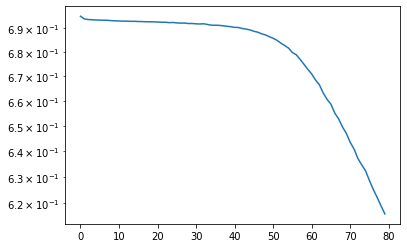

In [12]:
#history.history = hist_info
start_epoch = 0
end_epoch = -20

if plot_lr_rate:
    plt.plot(history.history['lr'][start_epoch:end_epoch], history.history['loss'][start_epoch:end_epoch])
    plt.xscale('log')
    lowest_loss_idx = np.argmin(history.history['loss'])
    print('best lr:',history.history['lr'][lowest_loss_idx])
elif decrease_lr_rate:
    plt.plot(history.history['lr'][start_epoch:end_epoch],history.history['loss'][start_epoch:end_epoch])
    plt.title('learning rate')
    plt.xscale('log')
    plt.xlim(max(history.history['lr'][start_epoch:end_epoch]), min(history.history['lr'][start_epoch:end_epoch]))
else:
    plt.plot(history.history['loss'][start_epoch:end_epoch])
    plt.yscale('log')

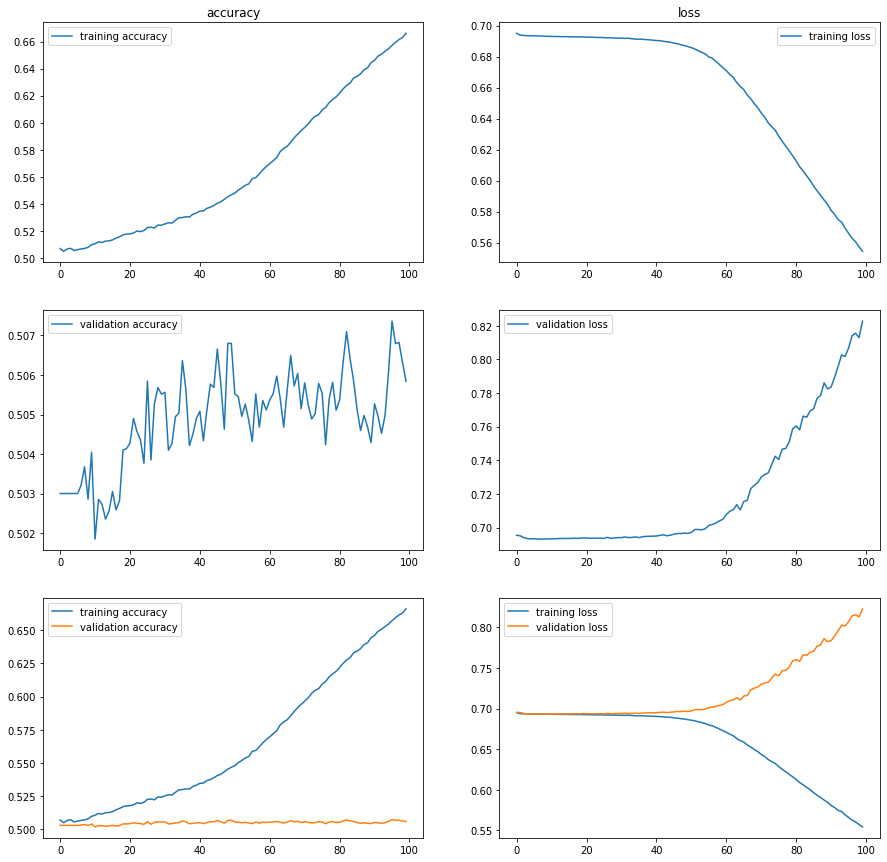

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,15))

metric = 'root_mean_squared_error' if problem_type == 'regression' else 'accuracy'
epoch_show_from = int(epochs * 0)
# metric
ax[0][0].plot(history.history[metric][epoch_show_from:])
ax[0][0].legend([f'training {metric}'])
ax[0][0].set_title(metric)
# loss
ax[0][1].plot(history.history['loss'][epoch_show_from:])
ax[0][1].legend([f'training loss'])
ax[0][1].set_title('loss')

if validation:
    # metric
    ax[1][0].plot(history.history[f'val_{metric}'][epoch_show_from:])
    ax[1][0].legend([f'validation {metric}'])
    ax[2][0].plot(history.history[metric][epoch_show_from:])
    ax[2][0].plot(history.history[f'val_{metric}'][epoch_show_from:])
    ax[2][0].legend([f'training {metric}',f'validation {metric}'])

    # loss
    ax[1][1].plot(history.history[f'val_loss'][epoch_show_from:])
    ax[1][1].legend([f'validation loss'])
    ax[2][1].plot(history.history['loss'][epoch_show_from:])
    ax[2][1].plot(history.history[f'val_loss'][epoch_show_from:])
    ax[2][1].legend([f'training loss',f'validation loss'])
else:
    ax[2][0].legend(['train'])
    ax[2][1].legend(['train'])

In [14]:
#raise Exception('stop at this cell')

In [15]:
def create_review_data_set(review_set):
    if review_set == 'train':
        review_x_data = x 
        review_y_data = y
        review_y_pct_diff = y_pct_diff
    elif review_set == 'test':
        review_x_data = x_test
        review_y_data = y_test
        review_y_pct_diff = y_test_pct_diff
    elif review_set == 'all':
        review_x_data = np.concatenate([x, x_test],axis=0)
        review_y_data = np.concatenate([y, y_test],axis=0)
        review_y_pct_diff = np.concatenate([y_pct_diff, y_test_pct_diff],axis=0)
    return review_x_data, review_y_data, review_y_pct_diff

def format_predictions_tanh(review_x_data):
    raw_predictions = model.predict(review_x_data)
    if problem_type == 'binary': 
        predictions_tanh = np.where(raw_predictions.flatten() < 0.5, -1, 1) 
    elif problem_type == 'category':
        class_idx = np.argmax(raw_predictions, axis=1)
        predictions_tanh = class_idx - 1
        raw_predictions[:, 0] = -raw_predictions[:, 0] 
        raw_predictions[:, 1] = 0
        raw_predictions = raw_predictions[range(raw_predictions.shape[0]),class_idx]
    else:
        predictions_tanh = raw_predictions.flatten()
    return raw_predictions, predictions_tanh

def cut_off_start_review_data_for_prediction():
    # cut off start of raw data until first prediction candle
    if review_set == 'train':
        review_data_raw = train_data_raw[window + num_bars -1:]
    elif review_set == 'test':
        review_data_raw = test_data_raw[window + num_bars -1:]
    elif review_set == 'all':
        review_data_raw = np.concatenate([train_data_raw[window + num_bars -1:], test_data_raw[window + num_bars -1:]],axis=0)
    
    if len(cols) != 1:
        review_data_raw = review_data_raw[:,-1]   
    
    return review_data_raw

def see_predictions(review_set): 
    review_x_data, review_y_data, review_y_pct_diff = create_review_data_set(review_set)
    raw_predictions, predictions_tanh = format_predictions_tanh(review_x_data)
    review_data_raw = cut_off_start_review_data_for_prediction()
    return review_data_raw, review_x_data, review_y_data, review_y_pct_diff, raw_predictions, predictions_tanh

pip_fees = 0
review_set = 'test' #'test' 'train' 'all'
dataset_type = 'stock'

file_name = list(loaded_files.keys())[5]
print(file_name)
x, y, x_test, y_test, y_pct_diff, y_test_pct_diff, train_data_raw, test_data_raw = create_dataset(
    file_name=file_name)

review_data_raw, review_x_data, review_y_data, review_y_pct_diff, raw_predictions, predictions_tanh = see_predictions(review_set)

AUDUSD_1h_2003-2020.csv


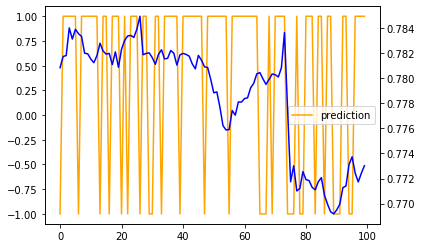

-1 to 1 range: 2


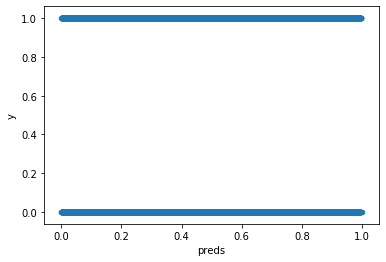

In [16]:
def plot_preds(bars_to_plot):
    fig, ax1 = plt.subplots()
    ax1.plot(predictions_tanh[:bars_to_plot], c='orange')
    ax1.legend(['prediction'])
    ax2 = ax1.twinx()
    ax2.plot(review_data_raw[:bars_to_plot], c='blue')
    #ax2.plot(review_ data_raw[input_len + num_bars: input_len + num_bars + bars_to_plot], c='blue')
    plt.show()
    smallest, biggest = predictions_tanh.min(), predictions_tanh.max()
    print(smallest,'to', biggest, 'range:', biggest - smallest )

bars_to_plot = 100
plot_preds(bars_to_plot)

preds = model.predict(x_test)
my_stuff = pd.DataFrame(pd.Series(preds.flatten(), name='preds'))
my_stuff['y'] = y_test
my_stuff.plot.scatter('preds','y')

avg_profit (0 pip fees) 2.105302497034985e-05
best possible profit (0 pip fees) 0.0028277866005610407


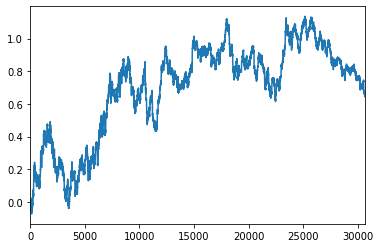

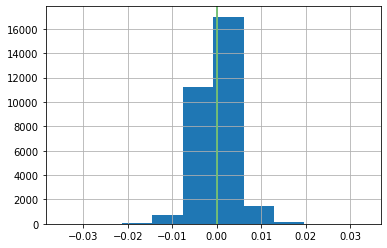

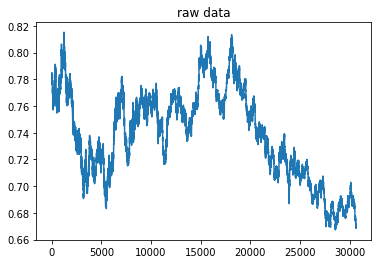

In [17]:
def calc_returns(review_data_raw, predictions_tanh, raw_predictions, review_y_pct_diff, pip_fees=1):
    returns = pd.DataFrame(pd.Series(review_data_raw, name='test_data_raw'))
    returns['y_pct_diff'] = review_y_pct_diff
    returns['predictions_tanh'] = pd.Series(predictions_tanh.flatten())
    returns['raw_predictions'] = pd.Series(raw_predictions.flatten())
    
    if problem_type == 'regression':
        returns['predictions_tanh'] = returns['raw_predictions'] - returns['test_data_raw']
        
    longs = returns.query('predictions_tanh > 0')
    flat = returns.query('predictions_tanh == 0')
    shorts = returns.query('predictions_tanh < 0')
    returns.loc[longs.index, 'profit'] = returns.loc[longs.index,'y_pct_diff'] - (0.0001 * pip_fees)
    returns.loc[flat.index, 'profit'] = 0
    returns.loc[shorts.index, 'profit'] = -returns.loc[shorts.index,'y_pct_diff'] - (0.0001 * pip_fees)
    returns['returns'] = returns['profit'].cumsum()
    avg_profit = returns['profit'].mean()
    print(f'avg_profit ({pip_fees} pip fees)',avg_profit)
    print(f'best possible profit ({pip_fees} pip fees)',returns['y_pct_diff'].abs().mean())
        
    return avg_profit, returns

def plot_returns():
    returns['returns'].plot()
    plt.show()
    ##
    ax = returns['profit'].hist()
    ax.axvline(0, c='k')
    ax.axvline(avg_profit, c='lightgreen')
    plt.show()
    
review_data_raw = review_data_raw.flatten()
avg_profit, returns = calc_returns(review_data_raw, predictions_tanh, raw_predictions, review_y_pct_diff, pip_fees=pip_fees)
plot_returns()

plt.plot(review_data_raw)
plt.title('raw data')
plt.show()

In [18]:
#raise Exception('stop at this cell')

### All files

In [19]:
pip_fees = 0
review_set = 'test' #'test' 'train' ' all'

all_returns = []
all_raw = []
for file_name in tqdm(list(loaded_files.keys())[:]):
    gc.collect()
    print(file_name)
    x, y, x_test, y_test, y_pct_diff, y_test_pct_diff, train_data_raw, test_data_raw = create_dataset(
        file_name=file_name)
    print(x.shape, x_test.shape)
    review_data_raw, review_x_data, review_y_data, review_y_pct_diff, raw_predictions, predictions_tanh = see_predictions(review_set)
    review_data_raw = review_data_raw.flatten()
    avg_profit, returns = calc_returns(review_data_raw, predictions_tanh, raw_predictions, review_y_pct_diff, pip_fees=pip_fees)
    num_trades = len(returns)
    print('no. trades:', num_trades)
    if resample:
        index_data = loaded_files[file_name].resample(resample).agg({'Open':'first','High':'max','Low':'min','Close':'last'})
    else:
        index_data = loaded_files[file_name]
    if review_set in ['train', 'all']:
        returns.index = index_data[:num_trades].index
    elif review_set == 'test':
        returns.index = index_data[-num_trades:].index
    returns['profit'].name=file_name
    returns['y_pct_diff'].name=file_name
    all_returns.append(returns['profit'])
    all_raw.append(returns['y_pct_diff'])

EURUSD_1h_2003-2010.csv
(29203, 10, 4) (12505, 10, 4)
avg_profit (0 pip fees) 5.2194896930854236e-05
best possible profit (0 pip fees) 0.0038829365300520127
no. trades: 12505
EURUSD_1h_2010-2020.csv
(42480, 10, 4) (18195, 10, 4)
avg_profit (0 pip fees) 3.9257588461771106e-05
best possible profit (0 pip fees) 0.0018697337161806857
no. trades: 18195
USDJPY_1h_2003-2010.csv
(29201, 10, 4) (12504, 10, 4)
avg_profit (0 pip fees) -6.372982704516107e-05
best possible profit (0 pip fees) 0.00417463393858346
no. trades: 12504
USDJPY_1h_2010-2020.csv
(43921, 10, 4) (18813, 10, 4)
avg_profit (0 pip fees) 3.717590837025355e-05
best possible profit (0 pip fees) 0.0020010606135041427
no. trades: 18813
NZDUSD_1h_2003-2020.csv
(72099, 10, 4) (30890, 10, 4)
avg_profit (0 pip fees) 1.7610261847847424e-06
best possible profit (0 pip fees) 0.0030363095743662877
no. trades: 30890
AUDUSD_1h_2003-2020.csv
(71540, 10, 4) (30650, 10, 4)
avg_profit (0 pip fees) 2.105302497034985e-05
best possible profit (0 pip 

suspect high stock trade: {}
suspect low stock trades: {}
averge profit (after 0 pip fees): 2.218500240753299e-05


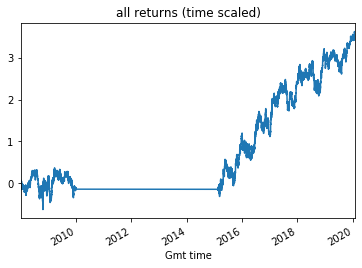

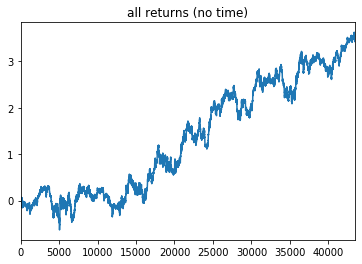

[ 0.09475716 -0.23112409 -0.00781364  1.30841592  0.011965    1.20215549
  0.64262975  0.49299183 -0.08732631]


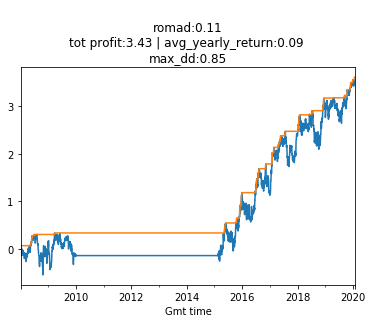

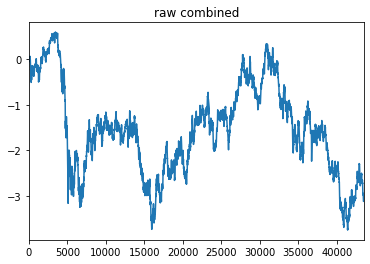

In [20]:
all_returns_final = pd.concat(all_returns, axis=1)
suspect_profits = all_returns_final.max(axis=0).sort_values(ascending=False)
suspect_high_stocks = list(suspect_profits[suspect_profits > 1].index) # larger than 100% gain on any trade
print('suspect high stock trade:', suspect_profits[suspect_profits > 1].round(2).to_dict())
suspect_losses = all_returns_final.min(axis=0).sort_values(ascending=True)
suspect_low_stocks = list(suspect_losses[suspect_losses < -0.5].index) # larger than -50% loss on any trade
print('suspect low stock trades:', suspect_losses[suspect_losses < -0.5].round(2).to_dict())
suspect_stocks = suspect_high_stocks + suspect_low_stocks

all_returns_final.drop(suspect_stocks, axis='columns', inplace=True)  
print(f'averge profit (after {pip_fees} pip fees):',np.nanmean(all_returns_final))
all_returns_final['profit'] = all_returns_final.sum(axis=1)
all_returns_final['returns'] = all_returns_final['profit'].cumsum()
all_returns_final['returns'].plot(title='all returns (time scaled)')
plt.show()
all_returns_final['returns'].reset_index(drop=True).plot(title='all returns (no time)')
plt.show()

romad = calc_romad(all_returns_final['profit'].resample('1D').sum(), filter_large_trades=0.5, yearly_agg=np.median, plot=True)

all_raw_final = pd.concat(all_raw, axis=1)
all_raw_final.drop(suspect_stocks, axis='columns', inplace=True) 
all_raw_final.sum(axis=1).cumsum().reset_index(drop=True).plot(title='raw combined')
plt.show()

In [21]:
raise Exception('stop at this cell')

Exception: stop at this cell

### Performance report

In [ ]:
rmse_func = lambda y, y_hat: mean_squared_error(y, y_hat)**0.5
scorer = rmse_func if problem_type == 'regression' else accuracy_score

if review_set == 'train':
    y_data = y
elif review_set == 'test':
    y_data = y_test
elif review_set == 'all':
    y_data = np.concatenate([y, y_test],axis=0)

if problem_type == 'category':
    logit_predictions = predictions_tanh + 1
else:
    logit_predictions = np.where(raw_predictions < 0.5, 0, 1) 

dumb_pred = scorer(y_data, np.zeros(len(y_data)))
print('Dumb:', dumb_pred)
model_score = scorer(y_data, logit_predictions.flatten())
print(f'{metric}:',model_score)
performance = dumb_pred - model_score if problem_type == 'regression' else model_score - dumb_pred
print('Performance:', performance)

In [ ]:
win = (returns['profit'] >= 0).sum()
loss = (returns['profit'] < 0).sum()
win_per = win / (win + loss)
print('win percetange',round(win_per,3))

In [ ]:
def bin_returns(returns):
    returns['pred_bins'] = pd.cut(returns['raw_predictions'], bins=20)
    grouped_returns = returns.groupby('pred_bins')

    fig, ax = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(15,8))
    grouped_returns.min()['profit'].plot.barh(title='min', ax=ax[0,0])
    grouped_returns.max()['profit'].plot.barh(title='max', ax=ax[0,1])
    grouped_returns.mean()['profit'].plot.barh(title='mean', ax=ax[1,0])
    grouped_returns.sum()['profit'].plot.barh(title='sum', ax=ax[1,1])
    grouped_returns.count()['profit'].plot.barh(title='count', ax=ax[1,2])
    plt.show()
    return grouped_returns


def filter_returns(returns, problem_type, upper_max=1, upper=0.75, lower=0.25, lower_min=0):
    if problem_type == 'binary': 
        filtered_returns = returns.query('((raw_predictions > @upper) & (raw_predictions < @upper_max)) | \
                                          ((raw_predictions > @lower_min) & (raw_predictions < @lower))').copy()
    elif problem_type == 'category': 
        filtered_returns = returns.query('((raw_predictions > @upper) & (raw_predictions < @upper_max)) | \
                                          ((raw_predictions > @lower_min) & (raw_predictions < @lower))').copy()
    else:
        filtered_returns = returns.query('(raw_predictions > @upper) | (raw_predictions < @lower)').copy()

    filtered_returns['returns'] = filtered_returns['profit'].cumsum()
    
    avg_filtered_profit = filtered_returns['profit'].mean()
    print('avg_filtered_profit:',avg_filtered_profit)
    avg_filtered_profit_pips = avg_filtered_profit* 10 ** 4
    print('avg_filtered_profit_pips:', avg_filtered_profit_pips)
    num_samples = len(filtered_returns)
    print('no. trades:',num_samples)
#     add_datetime_index(filtered_returns.copy()) 
#     sharpe = calc_sharpe(filtered_returns['profit'])
#     print('sharpe:', sharpe)
    return filtered_returns, avg_filtered_profit_pips, num_samples

In [ ]:
pip_fees = 1 # each instrument
review_set = 'test' #'test' 'train' 'all'

upper_max = 1 #0.65
upper = 0.6
lower = 0.4
lower_min = 0 #0.393

total_avg_weight_pips = []
for file_name in loaded_files.keys():
    gc.collect()
    print('\n-----',file_name)
    x, y, x_test, y_test, y_pct_diff, y_test_pct_diff, train_data_raw, test_data_raw = create_dataset(
        file_name=file_name)
    plt.plot(test_data_raw[:,-1])
    plt.title(file_name)
    plt.show()
    review_data_raw, review_x_data, review_y_data, review_y_pct_diff, raw_predictions, predictions_tanh = see_predictions(review_set)
    review_data_raw = review_data_raw.flatten()
    avg_profit, returns = calc_returns(review_data_raw, predictions_tanh, raw_predictions, review_y_pct_diff)
    returns['returns'].plot(title='returns')
    grouped_returns = bin_returns(returns)
    filtered_returns, avg_pips, samples = filter_returns(returns, problem_type, upper_max, upper, lower, lower_min)
    if len(filtered_returns) > 0:
        filtered_returns['returns'].plot()
        plt.show()
    total_avg_weight_pips.append([samples, avg_pips])
total_avg_weight_pips = np.array(total_avg_weight_pips)
tot_avg_pips = (total_avg_weight_pips[:,0] * total_avg_weight_pips[:,1]).sum() / total_avg_weight_pips[:,0].sum()
print('\n---\n total average pips per filtered trade:', round(tot_avg_pips, 4))